In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')


/Users/claudiacastro/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Recomendación. Campaña de email marketing.

# Objetivo

- Desarrollar una estrategia de email marketing dirigida a 10,000 clientes, priorizando los productos que generen mayor beneficio.



# Aspectos a tener en cuenta

1. Modelos de Predicción:

- Crear modelos predictivos para determinar qué productos tienen mayor probabilidad de ser contratados por cada cliente.
- Considerar no solo la probabilidad de contratación, sino también el beneficio económico de cada producto.
- Utilizar técnicas de modelado avanzadas como árboles de decisión, regresión logística y redes neuronales.
- Validar y evaluar los modelos utilizando métricas como la precisión, el recall y el AUC-ROC.
2. Selección de Clientes:
- Seleccionar los 10,000 clientes que recibirán los emails basados en los resultados del modelo predictivo.
- Justificar la elección de estos clientes y la estrategia empleada.

# Enfoques para la creación de los modelos predictivos

1. Creación de un modelo para cada producto:

- En este enfoque, se crearía un modelo predictivo separado para cada producto (por ejemplo, uno para short_term_deposit, otro para loans, otro para mortgage, etc.).

- Ventajas: Es específico para cada producto. El modelo se entrenaría específicamente para un producto, lo que permite que aprenda patrones únicos relacionados con la contratación de ese producto.
- Interpretabilidad: Los factores que influyen en la contratación de cada producto pueden ser más fáciles de interpretar.
- Desventajas: Sería costoso en términos de recursos ya que requiere entrenar y mantener múltiples modelos. Además, muchos de los modelos podrían utilizar características similares, lo que significa que se estaría trabajando doble.

2. Modelo agrupado por tipos de productos:

- Se agruparían los productos similares en categorías, exactamente como lo explicaba Erin (Responsable de Marketing Directo) en uno de sus correos [cuentas, productos de ahorro e inversión (planes, fondos, etc.) y financiación (préstamos y tarjetas)].

- Ventajas: Menos modelos que mantener en comparación con la opción de un modelo por producto. Además, se pueden identificar patrones que se aplican a categorías de productos.
- Desventajas: Puede que no capture detalles específicos de un solo producto tan bien como un modelo dedicado.

3. Modelo General para Todos los Productos:

- Se utilizaría un único modelo para predecir la probabilidad de que un cliente contrate cualquier producto.
- Ventajas: Es simple, solo hay que entrenar y mantener un único modelo, por tanto menos recursos computacionales y menos tiempo de entrenamiento.
- Desventajas: Puede ser más complejo interpretar las relaciones ya que el modelo tiene que captar información de todos los productos y si un producto es raro comparado con otros, el modelo puede no predecirlo correctamente.



# Procedimiento para la creación de los modelos predictivos.

Teniendo en cuenta lo anterior, a continuación se muestra el procedimiento a deasrrollar para resolver esta Tarea:

- Se trabajará a partir de un Modelo General Inicial que prediga la probabilidad de contratación de productos en general.


1. Preparación de Datos

- Se carga el dataset df_full_cleaned desde S3 de AWS
  
- Se crea la variable objetivo (compra): una columna binaria que indica si el cliente ha comprado algún producto (1) o no (0), independientemente del producto que sea, es decir, si al menos a comprado un producto es (1) si no es (0) .
- Se hace la partición de los datos en conjunto de entrenamiento (60%), validación(20%) y prueba(20%).
 
- El conjunto de validación se usa para evaluar el modelo durante todo el proceso de ajuste, desde la Iteración 1 hasta la 3, permitiendo ver cómo el modelo generaliza a datos que no ha visto durante el entrenamiento.

- En la última etapa se selecciona el mejor modelo y se hace un ajuste de hiperparámetros, para luego hacer una evaluación final con el conjunto de prueba para obtener una medida objetiva de la capacidad del modelo para generalizar a datos completamente nuevos.



2. Iteración 1: Modelos Iniciales. Para el entrenamiento se van a tener en cuenta los siguientes modelos:

- Regresión Logística
- Random Forest
- XGBoost
- K-Nearest Neighbors (KNN)
- Support Vector Machine (SVM)

- Se realiza un análisis de correlación de las variables numéricas eliminando las que presenten una alta correlacción (> 90%).
  
- Se usará accuracy, precision, recall, F1-score para evaluar el rendimiento de cada modelo en el conjunto de validación y se analiza el comportamiento de los modelos. 



1. Iteración 2: Feature Engineering

- Se crean nuevas características, generando interacciones o combinaciones de variables.

- Se repite un análisis de correlación de las variables numéricas eliminando las que presenten una alta correlacción (> 90%).

- Se entrena y evalua los mismos modelos que en la iteración 1, con las nuevas características.

1. Iteración 3: Refinamiento del Modelo

- Análisis de las características menos relevantes según su importancia en los modelos anteriores.

- Se vuelven a entrenar los modelos, se evaluan y se comparan los resultados.

5. Selección del modelo y ajuste de hiperparámetros

- A partir del modelo que mejor comportamiento presente se realiza un ajuste de hiperparámetros usando GridSearchCV. 
 
- Se evalua el rendimiento final del modelo ajustado tanto en el conjunto de validación como de test.







---

## Preparación de datos.

In [2]:
# cargando el dataset completo directamente desde S3 de AWS

df_full = pd.read_parquet("https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/df_full_cleaned.parquet")
df_full

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad
0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,1,January,Adultos jóvenes,"87,218.100",Málaga,2018-01-12,Otros,1,02 - PARTICULARES,1-2 años
1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"35,548.740",Ciudad Real,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años
2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"122,179.110",Ciudad Real,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,40,0,ES,H,1,January,Jóvenes,"119,775.540",Zaragoza,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años
4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"101,469.135",Zaragoza,2015-08-10,KHE,1,03 - UNIVERSITARIO,Más de 3 años
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"43,912.170",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años
5962920,1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"23,334.990","Rioja, La",2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años
5962921,1166763,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Adultos,"87,930.930",Zaragoza,2016-08-14,KHE,1,02 - PARTICULARES,2-3 años
5962922,1166789,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Jóvenes,"199,592.820",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años


In [3]:
# se agrupa los productos por cliente y se calcula la media de los productos
# lo cual indica la actividad de cada cliente en cada producto

lista_productos = ["pk_cid","short_term_deposit", "loans", "mortgage", "funds", "securities", 
                   "long_term_deposit", "credit_card", "payroll_account", 
                   "emc_account", "debit_card", "em_acount", "payroll", "pension_plan"]

df_productos = df_full[lista_productos].groupby("pk_cid").mean()
df_productos


,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll_account,emc_account,debit_card,em_acount,payroll,pension_plan
pk_cid,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,0.000,0.000
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833,0.000,0.000
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.889,0.000,0.000
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.294,1.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1553686,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1553687,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [4]:
# columnas a utilizar sacadas del dataset completo que se van a utilizar para el modelo


columnas_relevantes = ["pk_cid","country_id"	,"gender", "median_salary",	"region_code",	
                       "entry_date","entry_channel"	,"active_customer",	"segment",	"categoria_antiguedad", "num_products_contracts"]

# se agrupa el dataset por las columnas relevantes por cliente y se toma la última fila de cada cliente
# ya estas columnas vienen limpias y listas para ser utilizadas en el modelo de la tarea anterior
df_relevantes = df_full[columnas_relevantes].groupby("pk_cid").last()

In [5]:
# se importa el dataset de sociodemográfico que se limpió en la tarea anterior
# para obtener la edad de cada cliente y trabajar con ella en el modelo
sociod = pd.read_parquet('https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/sociodemographic_df.parquet')
edad = sociod.groupby("pk_cid").last()

In [6]:
# se unen los datasets de productos y relevantes para tener un dataset completo
# con todas las columnas necesarias para el modelo
df_fulll = df_productos.merge(df_relevantes, on = "pk_cid")
df_fulll = df_fulll.merge(edad["age"], on = "pk_cid")
df_fulll

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll_account,emc_account,debit_card,em_acount,payroll,pension_plan,country_id,gender,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,num_products_contracts,age
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,0.000,0.000,ES,H,"117,380.925",Madrid,2018-07-28,KAT,0,02 - PARTICULARES,0-3 meses,0,59
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,ES,H,"132,384.450",Madrid,2018-11-19,KAT,0,02 - PARTICULARES,6-9 meses,0,62
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833,0.000,0.000,ES,V,"153,902.880",Barcelona,2018-12-23,KAT,1,01 - TOP,3-6 meses,1,70
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.889,0.000,0.000,ES,H,"132,384.450",Madrid,2018-09-30,KHN,1,02 - PARTICULARES,6-9 meses,2,58
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.294,1.000,0.000,0.000,ES,H,"102,405.750",Madrid,2017-09-16,KAT,1,02 - PARTICULARES,1-2 años,3,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,ES,V,"114,633.765",Ciudad Real,2019-05-31,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,52
1553686,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,ES,H,"85,787.220",Sevilla,2019-05-31,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,30
1553687,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,ES,V,"143,419.770",Madrid,2019-05-31,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,21


Otras transformaciones necesarias para el modelo

In [7]:
# se reemplazan los valores en region_code por la frecuencia de cada provincia
# Paso 1: Calcular la frecuencia de cada provincia
frecuencias_provincia = df_fulll['region_code'].value_counts(normalize=True)  # normalize=True para obtener las frecuencias relativas
# Paso 2: Mapear las frecuencias a la columna de provincia
df_fulll['region_code_frecuency'] = df_fulll['region_code'].map(frecuencias_provincia)

#lo mismo que el paso anterior pero con entry_channel
frecuencias_entry_channel = df_fulll['entry_channel'].value_counts(normalize=True) 
df_fulll['entry_channel_frecuency'] = df_fulll['entry_channel'].map(frecuencias_entry_channel)

In [8]:
# Se lleva df_fulll["entry_date"] a formato numerico
df_fulll["entry_date"] = df_fulll["entry_date"].apply(lambda x: x.toordinal())

In [9]:
#df_fulll["country_id"].value_counts("ES" , normalize = True)
# quiero saber cuantos no son ES
df_fulll["country_id"] = df_fulll["country_id"].apply(lambda x: 1 if x == "ES" else 0)
df_fulll["country_id"].value_counts()


country_id
1    456209
0       164
Name: count, dtype: int64

Como solo 164 clientes son extranjeros, es decir, no son "ES", se va a eliminar esa columna, no aporta suficiente información.

In [10]:
df_fulll.drop("country_id", axis = 1, inplace = True)
df_completo = df_fulll.copy()
df_fulll

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll_account,emc_account,debit_card,em_acount,payroll,pension_plan,gender,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,num_products_contracts,age,region_code_frecuency,entry_channel_frecuency
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,0.000,0.000,H,"117,380.925",Madrid,736903,KAT,0,02 - PARTICULARES,0-3 meses,0,59,0.215,0.059
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,H,"132,384.450",Madrid,737017,KAT,0,02 - PARTICULARES,6-9 meses,0,62,0.215,0.059
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833,0.000,0.000,V,"153,902.880",Barcelona,737051,KAT,1,01 - TOP,3-6 meses,1,70,0.101,0.059
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.889,0.000,0.000,H,"132,384.450",Madrid,736967,KHN,1,02 - PARTICULARES,6-9 meses,2,58,0.215,0.037
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.294,1.000,0.000,0.000,H,"102,405.750",Madrid,736588,KAT,1,02 - PARTICULARES,1-2 años,3,54,0.215,0.059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,V,"114,633.765",Ciudad Real,737210,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,52,0.011,0.035
1553686,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,H,"85,787.220",Sevilla,737210,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,30,0.047,0.035
1553687,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,V,"143,419.770",Madrid,737210,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,21,0.215,0.035


In [11]:
# transformación de variables objects a categóricas
df_fulll["gender"] = df_fulll["gender"].astype("category")

# eliminación de columnas que no se van a utilizar en el modelo
df_fulll.drop("region_code", axis = 1, inplace = True)
df_fulll.drop("entry_channel", axis = 1, inplace = True)

Ya por último, creamos la variable objetivo, la que vamos a predecir

In [12]:
# IMPORTANTE
# Se Crea la variable objetivo
# Se crea una variable objetivo que indica si el cliente ha comprado algún producto o no

df_fulll["compra"] = df_fulll["num_products_contracts"].apply(lambda x: 1 if x > 0 else 0)

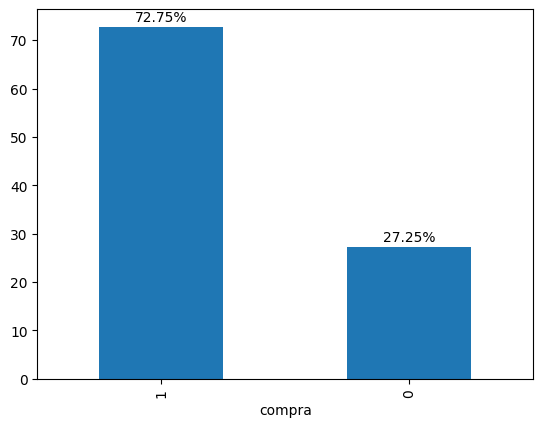

In [13]:
# Comportamiento de la variable objetivo

(df_fulll["compra"].value_counts(normalize=True)*100).plot(kind="bar")
for i, v in enumerate(df_fulll["compra"].value_counts(normalize=True)*100):
    plt.text(i, v + 0.5, str(round(v, 2)) + "%", ha='center', va='bottom')

Se observa que la variable objetivo está un poco desbalanceada, lo cual se tendré en cuenta a la hora de trabajar.

---

### 1. Iteración 1 (baseline).

#### División de los conjuntos, selección de columnas numericas y categóricas y analisis de correlación de las numéricas.

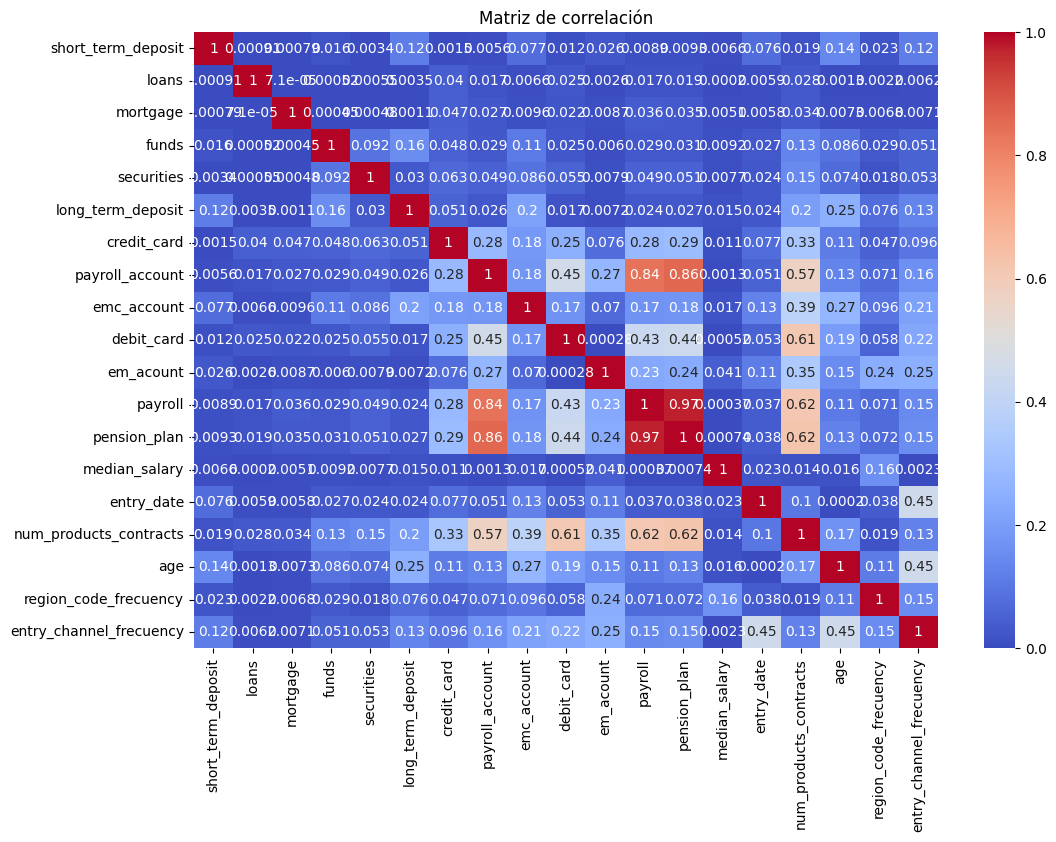

Columnas que no pasan al siguiente análisis debido a alta correlación: ['pension_plan']


In [14]:


# 1. Cargar el dataset
X_full = df_fulll.copy()

y = X_full['compra']  # Variable objetivo
X_full.drop(['compra'], axis=1, inplace=True)

# 4. Dividir los datos en entrenamiento (60%), validación (20%) y test (20%)
# El 60% de los datos originales se asigna al conjunto de entrenamiento (X_train_full y y_train).
# El 40% restante se divide en dos partes iguales: el 20% para el conjunto de validación (X_valid_full y y_valid) 
# y el 20% para el conjunto de prueba (X_test_full y y_test).
X_train_full, X_temp, y_train, y_temp = train_test_split(X_full, y, train_size=0.6, test_size=0.4, random_state=11, stratify=y)
X_valid_full, X_test_full, y_valid, y_test = train_test_split(X_temp, y_temp, train_size=0.5, test_size=0.5, random_state=11, stratify=y_temp)

# 5. Seleccionar columnas categóricas y numéricas
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype == "category"]
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]
my_cols = categorical_cols + numerical_cols 
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()
    
#---------------------------------------------------------

# 1. Calcular la matriz de correlación para las columnas numéricas
correlation_matrix = X_train[numerical_cols].corr().abs()

# 2. Visualizar la matriz de correlación como un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Matriz de correlación")
plt.show()

# 3. Identificar columnas con correlación mayor a 0.90
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Encuentra las columnas que tienen correlación > 0.90
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]

# 4. Eliminar columnas con alta correlación en el conjunto de entrenamiento
X_train = X_train.drop(columns=to_drop)
X_valid = X_valid.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

# Mostrar columnas eliminadas
print("Columnas que no pasan al siguiente análisis debido a alta correlación:", to_drop)

#---------------------------------------------------------



#### Definición del preprocesamiento, definición de los modelos, entrenamiento y evaluación de cada uno de los modelos seleccionados.

NOTA: por tiempos de ejecución muy elevados, se va a trabajar con 3 de los 5 modelos seleccionados.

In [15]:
# 6. Preprocesamiento de los datos
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ]
)

# 7. Definir modelos a evaluar
models = {
    'RandomForest': RandomForestClassifier(random_state=11, n_jobs=-1),
    "LogisticRegression": LogisticRegression(random_state=11, n_jobs=-1),
    "XGBClassifier": XGBClassifier(random_state=11, n_jobs=-1),
      # "KNN": KNeighborsClassifier( n_jobs=-1),
    # "SVM": SVC( random_state=11),
}

# Diccionario para almacenar las importancias de características por modelo
feature_importances = {}

# 8. Entrenar y evaluar cada modelo
tabla_metricas = pd.DataFrame(columns=['Modelo', "accuracy", "roc_auc", "f1_score", "precision", "recall"])

for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Entrenar el modelo
    clf.fit(X_train, y_train)
    
    # Predicciones
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]
    
    # Calcular métricas
    accuracy = accuracy_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_pred_proba)
    f1 = f1_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    
    # Añadir las métricas a la tabla
    new_row = pd.DataFrame({'Modelo': [name], 'accuracy': [accuracy], 
                            'roc_auc': [roc_auc], 'f1_score': [f1], 
                            'precision': [precision], 'recall': [recall]})
    tabla_metricas = pd.concat([tabla_metricas, new_row], ignore_index=True)
    
    # Extraer e integrar las importancias de las características según el modelo
    if hasattr(model, 'feature_importances_'):  # Para RandomForest y XGBClassifier
        # Obtener las importancias de características del modelo
        importances = model.feature_importances_
        feature_names = clf.named_steps['preprocessor'].transformers_[0][1]['onehot'].get_feature_names_out(categorical_cols)
        feature_importances[name] = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    
    elif hasattr(model, 'coef_'):  # Para LogisticRegression
        # Obtener los coeficientes del modelo
        coefficients = model.coef_[0]
        feature_names = clf.named_steps['preprocessor'].transformers_[0][1]['onehot'].get_feature_names_out(categorical_cols)
        feature_importances[name] = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})

# 11. Mostrar las métricas
print("Tabla de métricas:")
print(tabla_metricas)

# 12. Mostrar las importancias de las características por cada modelo
for model_name, importance_df in feature_importances.items():
    print(f"Importancias de características para {model_name}:")
    print(importance_df.sort_values(by='Importance', ascending=False))

Tabla de métricas:
               Modelo  accuracy  roc_auc  f1_score  precision  recall
0        RandomForest     0.740    0.650     0.847      0.740   0.990
1  LogisticRegression     0.738    0.641     0.845      0.744   0.977
2       XGBClassifier     0.740    0.650     0.846      0.741   0.986
Importancias de características para RandomForest:
                               Feature  Importance
5       categoria_antiguedad_0-3 meses       0.419
3            segment_02 - PARTICULARES       0.147
4           segment_03 - UNIVERSITARIO       0.098
11  categoria_antiguedad_Más de 3 años       0.085
9       categoria_antiguedad_6-9 meses       0.054
8       categoria_antiguedad_3-6 meses       0.054
10     categoria_antiguedad_9-12 meses       0.043
7        categoria_antiguedad_2-3 años       0.038
6        categoria_antiguedad_1-2 años       0.031
2                     segment_01 - TOP       0.024
0                             gender_H       0.004
1                             gender_V

#### Comparación de modelos

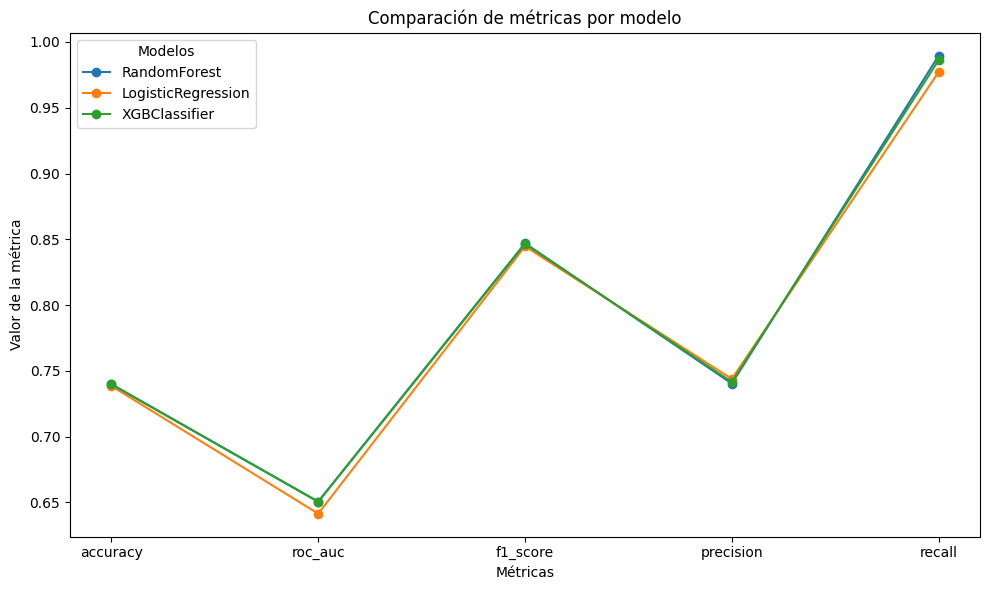

In [16]:
# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Definir las métricas que se usarán como etiquetas en el eje X
metricas = ['accuracy', 'roc_auc', 'f1_score', 'precision', 'recall']

# Graficar una línea por cada modelo
for modelo in tabla_metricas['Modelo']:
    plt.plot(metricas, tabla_metricas[tabla_metricas['Modelo'] == modelo].iloc[0, 1:], marker='o', label=modelo)

# Añadir etiquetas y título
plt.xlabel('Métricas')
plt.ylabel('Valor de la métrica')
plt.title('Comparación de métricas por modelo')
plt.legend(title='Modelos')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Hasta el momento:

- De forma general, los tres modelos tienen un comportamiento bastante similar.
  
- La variable categoria_antiguedad y segment son unas de las características más importantes presente en cada modelo analizado.

---

### 2. Iteración 2.

- La variable categoria_antiguedad es una de las características más importantes del modelo, lo que sugiere que la antigüedad del cliente tiene un fuerte impacto en su comportamiento. Sin embargo, la variable categoria_antiguedad por sí sola no captura el contexto temporal en el que esa antigüedad ocurre. 
 
- Por tanto, vamos a incluir la variable pk_partition a partir de nuevas variables como por ejemplo Duracion activa del cliente, Primer periodo activo, entre otras; que permitan capturar patrones temporales en el comportamiento de los clientes y de esta forma poder enriquecer la interpretación de variables importantes.

#### Preparación del dataset y creación de nuevas características

In [17]:
# Vamos a usar los datos de `pk_cid` y `pk_partition` para crear un dataset
# donde cada fila sea un cliente y cada columna sea una partición temporal
# indicando si el cliente estuvo presente o no en cada partición temporal

df_presence = df_full.pivot_table(index='pk_cid', columns='pk_partition', fill_value=0, aggfunc='size')
df_presence

pk_partition,2018-01-28,2018-02-28,2018-03-28,2018-04-28,2018-05-28,2018-06-28,2018-07-28,2018-08-28,2018-09-28,2018-10-28,2018-11-28,2018-12-28,2019-01-28,2019-02-28,2019-03-28,2019-04-28,2019-05-28
pk_cid,,,,,,,,,,,,,,,,,
15891,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
16063,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1
16203,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1
16502,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1
17457,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1553686,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1553687,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


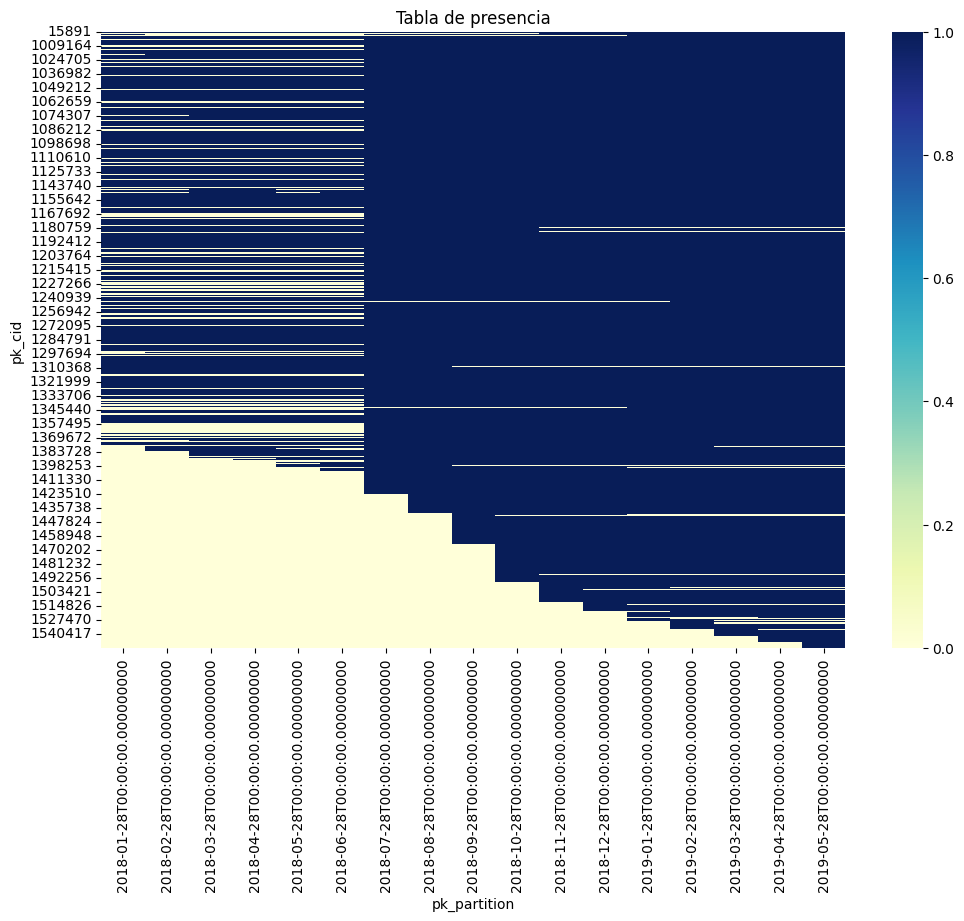

In [18]:
# A continuacion se muestra la tabla de presencia de los clientes en cada partición temporal
# donde 1 indica que el cliente estuvo presente y 0 que no estuvo presente
# en cada partición temporal
plt.figure(figsize=(12, 8))
sns.heatmap(df_presence, cmap= "YlGnBu", cbar=True)
plt.title("Tabla de presencia")
plt.show()


Clientes con Actividad Constante:
- Un grupo de clientes aparece de manera regular en todas las particiones. Son probablemente clientes leales y valiosos para el negocio.
  
Clientes con Actividad Intermitente:
- Algunos clientes tienen presencia irregular en diferentes particiones.

Nuevos Clientes:
- En las particiones recientes, vemos clientes nuevos. Es importante monitorear su comportamiento para asegurar su retención a largo plazo.

Clientes de Ciclo de Vida Corto:
- Algunos clientes aparecen en una o dos particiones y luego desaparecen.

---

Creando nuevas variables a partir del analisis de clientes según comportamiento a lo largo de pk_partition

- Duración de actividad del cliente: 
permite identificar realmente cuánto estuvo activo un cliente, dando una idea de su “lealtad” o permanencia. Esto te dará una medida de la duración de su ciclo de vida.

In [19]:
df_presence['months_active'] = df_presence.sum(axis=1)
df_presence

pk_partition,2018-01-28 00:00:00,2018-02-28 00:00:00,2018-03-28 00:00:00,2018-04-28 00:00:00,2018-05-28 00:00:00,2018-06-28 00:00:00,2018-07-28 00:00:00,2018-08-28 00:00:00,2018-09-28 00:00:00,2018-10-28 00:00:00,2018-11-28 00:00:00,2018-12-28 00:00:00,2019-01-28 00:00:00,2019-02-28 00:00:00,2019-03-28 00:00:00,2019-04-28 00:00:00,2019-05-28 00:00:00,months_active
pk_cid,,,,,,,,,,,,,,,,,,
15891,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2
16063,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,7
16203,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6
16502,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,9
17457,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1553686,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1553687,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


- Primer Período Activo. Esto puede ser útil para crear análisis de cohortes o para observar patrones en los primeros períodos de actividad de un cliente.

In [20]:
particiones_columnas = df_presence.columns[:17]
particiones_columnas

Index([2018-01-28 00:00:00, 2018-02-28 00:00:00, 2018-03-28 00:00:00,
       2018-04-28 00:00:00, 2018-05-28 00:00:00, 2018-06-28 00:00:00,
       2018-07-28 00:00:00, 2018-08-28 00:00:00, 2018-09-28 00:00:00,
       2018-10-28 00:00:00, 2018-11-28 00:00:00, 2018-12-28 00:00:00,
       2019-01-28 00:00:00, 2019-02-28 00:00:00, 2019-03-28 00:00:00,
       2019-04-28 00:00:00, 2019-05-28 00:00:00],
      dtype='object', name='pk_partition')

In [21]:
# se obtiene la primera columna que es 1 para cada cliente

df_presence["first_active_month"] = df_presence[particiones_columnas].apply(lambda x: x.idxmax(), axis=1)
df_presence.head()


pk_partition,2018-01-28 00:00:00,2018-02-28 00:00:00,2018-03-28 00:00:00,2018-04-28 00:00:00,2018-05-28 00:00:00,2018-06-28 00:00:00,2018-07-28 00:00:00,2018-08-28 00:00:00,2018-09-28 00:00:00,2018-10-28 00:00:00,2018-11-28 00:00:00,2018-12-28 00:00:00,2019-01-28 00:00:00,2019-02-28 00:00:00,2019-03-28 00:00:00,2019-04-28 00:00:00,2019-05-28 00:00:00,months_active,first_active_month
pk_cid,,,,,,,,,,,,,,,,,,,
15891,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2,2018-07-28
16063,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,7,2018-11-28
16203,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6,2018-12-28
16502,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,9,2018-09-28
17457,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,17,2018-01-28


- Último Mes Activo: último mes en el que un cliente estuvo activo, lo cual te permitirá identificar clientes que ya no están activos o que han “desaparecido”.


In [22]:
df_presence['last_active_month'] = df_presence[particiones_columnas].apply(lambda row: row[::-1].idxmax(), axis=1)
df_presence.head()

pk_partition,2018-01-28 00:00:00,2018-02-28 00:00:00,2018-03-28 00:00:00,2018-04-28 00:00:00,2018-05-28 00:00:00,2018-06-28 00:00:00,2018-07-28 00:00:00,2018-08-28 00:00:00,2018-09-28 00:00:00,2018-10-28 00:00:00,2018-11-28 00:00:00,2018-12-28 00:00:00,2019-01-28 00:00:00,2019-02-28 00:00:00,2019-03-28 00:00:00,2019-04-28 00:00:00,2019-05-28 00:00:00,months_active,first_active_month,last_active_month
pk_cid,,,,,,,,,,,,,,,,,,,,
15891,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2,2018-07-28,2018-08-28
16063,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,7,2018-11-28,2019-05-28
16203,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6,2018-12-28,2019-05-28
16502,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,9,2018-09-28,2019-05-28
17457,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,17,2018-01-28,2019-05-28


- Consistencia en la Actividad: mide qué tan seguido el cliente se mantiene activo de forma continua sin saltos de inactividad.


Proporción de meses activos frente al total de meses desde su primera actividad hasta la última.


In [23]:
# Supongamos que ya tienes las columnas 'first_active_month' y 'last_active_month' correctamente definidas
df_presence['first_active_month'] = pd.to_datetime(df_presence['first_active_month'])
df_presence['last_active_month'] = pd.to_datetime(df_presence['last_active_month'])

# Calcular la duración entre el primer y último mes de actividad en meses
df_presence['activity_duration_months'] = (df_presence['last_active_month'] - df_presence['first_active_month']).dt.days // 30

# Evitar divisiones por 0. Si la duración es 0, establecemos la consistencia como 1
df_presence['activity_duration_months'] = df_presence['activity_duration_months'].replace(0, 1)

# Ahora calculamos la consistencia como la proporción de meses activos sobre la duración de la actividad
df_presence['activity_consistency'] = df_presence['months_active'] / df_presence['activity_duration_months']

# Revisar el DataFrame con las nuevas columnas
df_presence.head()

pk_partition,2018-01-28 00:00:00,2018-02-28 00:00:00,2018-03-28 00:00:00,2018-04-28 00:00:00,2018-05-28 00:00:00,2018-06-28 00:00:00,2018-07-28 00:00:00,2018-08-28 00:00:00,2018-09-28 00:00:00,2018-10-28 00:00:00,2018-11-28 00:00:00,2018-12-28 00:00:00,2019-01-28 00:00:00,2019-02-28 00:00:00,2019-03-28 00:00:00,2019-04-28 00:00:00,2019-05-28 00:00:00,months_active,first_active_month,last_active_month,activity_duration_months,activity_consistency
pk_cid,,,,,,,,,,,,,,,,,,,,,,
15891,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2,2018-07-28,2018-08-28,1,2.000
16063,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,7,2018-11-28,2019-05-28,6,1.167
16203,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6,2018-12-28,2019-05-28,5,1.200
16502,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,9,2018-09-28,2019-05-28,8,1.125
17457,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,17,2018-01-28,2019-05-28,16,1.062


In [24]:
# eliminar columnas que no se necesitan
df_presence.drop(['activity_duration_months'], axis=1, inplace=True)
df_presence.head()

pk_partition,2018-01-28 00:00:00,2018-02-28 00:00:00,2018-03-28 00:00:00,2018-04-28 00:00:00,2018-05-28 00:00:00,2018-06-28 00:00:00,2018-07-28 00:00:00,2018-08-28 00:00:00,2018-09-28 00:00:00,2018-10-28 00:00:00,2018-11-28 00:00:00,2018-12-28 00:00:00,2019-01-28 00:00:00,2019-02-28 00:00:00,2019-03-28 00:00:00,2019-04-28 00:00:00,2019-05-28 00:00:00,months_active,first_active_month,last_active_month,activity_consistency
pk_cid,,,,,,,,,,,,,,,,,,,,,
15891,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2,2018-07-28,2018-08-28,2.000
16063,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,7,2018-11-28,2019-05-28,1.167
16203,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6,2018-12-28,2019-05-28,1.200
16502,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,9,2018-09-28,2019-05-28,1.125
17457,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,17,2018-01-28,2019-05-28,1.062


In [25]:
# Solo cambiar columnas que contengan años 2018 o 2019
df_presence.columns = [pd.to_datetime(col).strftime('%b-%Y') if '2018' in str(col) or '2019' in str(col) else col for col in df_presence.columns]

df_presence

,Jan-2018,Feb-2018,Mar-2018,Apr-2018,May-2018,Jun-2018,Jul-2018,Aug-2018,Sep-2018,Oct-2018,Nov-2018,Dec-2018,Jan-2019,Feb-2019,Mar-2019,Apr-2019,May-2019,months_active,first_active_month,last_active_month,activity_consistency
pk_cid,,,,,,,,,,,,,,,,,,,,,
15891,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2,2018-07-28,2018-08-28,2.000
16063,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,7,2018-11-28,2019-05-28,1.167
16203,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6,2018-12-28,2019-05-28,1.200
16502,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,9,2018-09-28,2019-05-28,1.125
17457,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,17,2018-01-28,2019-05-28,1.062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2019-05-28,2019-05-28,1.000
1553686,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2019-05-28,2019-05-28,1.000
1553687,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2019-05-28,2019-05-28,1.000


Ya por ultimo unimos el dataframe df_presence con el df_fulll que analizamos en la Iteracion 1, y hacemos unas ultimas tranformaciones

In [26]:
# unir el dataset de presencia con el dataset df_fulll
#df_iterac_2 = df_fulll.merge(df_presence[["months_active", "first_active_month", "last_active_month"	,"activity_consistency"]], on = "pk_cid")
df_iterac_2 = df_fulll.merge(df_presence, on = "pk_cid")



# llevar colunmas first_active_mont y last_active_month a numerico
df_iterac_2["first_active_month"] = df_iterac_2["first_active_month"].apply(lambda x: x.toordinal())
df_iterac_2["last_active_month"] = df_iterac_2["last_active_month"].apply(lambda x: x.toordinal()) 


df_iterac_2.head()

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll_account,emc_account,debit_card,em_acount,payroll,pension_plan,gender,median_salary,entry_date,active_customer,segment,categoria_antiguedad,num_products_contracts,age,region_code_frecuency,entry_channel_frecuency,compra,Jan-2018,Feb-2018,Mar-2018,Apr-2018,May-2018,Jun-2018,Jul-2018,Aug-2018,Sep-2018,Oct-2018,Nov-2018,Dec-2018,Jan-2019,Feb-2019,Mar-2019,Apr-2019,May-2019,months_active,first_active_month,last_active_month,activity_consistency
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,0.000,0.000,H,"117,380.925",736903,0,02 - PARTICULARES,0-3 meses,0,59,0.215,0.059,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2,736903,736934,2.000
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,H,"132,384.450",737017,0,02 - PARTICULARES,6-9 meses,0,62,0.215,0.059,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,7,737026,737207,1.167
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833,0.000,0.000,V,"153,902.880",737051,1,01 - TOP,3-6 meses,1,70,0.101,0.059,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6,737056,737207,1.200
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.889,0.000,0.000,H,"132,384.450",736967,1,02 - PARTICULARES,6-9 meses,2,58,0.215,0.037,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,9,736965,737207,1.125
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.294,1.000,0.000,0.000,H,"102,405.750",736588,1,02 - PARTICULARES,1-2 años,3,54,0.215,0.059,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,17,736722,737207,1.062


In [27]:
df_iterac_2 = df_iterac_2.merge(df_completo[["entry_channel", "region_code"]], on = "pk_cid")
df_iterac_2

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll_account,emc_account,debit_card,em_acount,payroll,pension_plan,gender,median_salary,entry_date,active_customer,segment,categoria_antiguedad,num_products_contracts,age,region_code_frecuency,entry_channel_frecuency,compra,Jan-2018,Feb-2018,Mar-2018,Apr-2018,May-2018,Jun-2018,Jul-2018,Aug-2018,Sep-2018,Oct-2018,Nov-2018,Dec-2018,Jan-2019,Feb-2019,Mar-2019,Apr-2019,May-2019,months_active,first_active_month,last_active_month,activity_consistency,entry_channel,region_code
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,0.000,0.000,H,"117,380.925",736903,0,02 - PARTICULARES,0-3 meses,0,59,0.215,0.059,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2,736903,736934,2.000,KAT,Madrid
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,H,"132,384.450",737017,0,02 - PARTICULARES,6-9 meses,0,62,0.215,0.059,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,7,737026,737207,1.167,KAT,Madrid
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833,0.000,0.000,V,"153,902.880",737051,1,01 - TOP,3-6 meses,1,70,0.101,0.059,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6,737056,737207,1.200,KAT,Barcelona
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.889,0.000,0.000,H,"132,384.450",736967,1,02 - PARTICULARES,6-9 meses,2,58,0.215,0.037,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,9,736965,737207,1.125,KHN,Madrid
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.294,1.000,0.000,0.000,H,"102,405.750",736588,1,02 - PARTICULARES,1-2 años,3,54,0.215,0.059,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,17,736722,737207,1.062,KAT,Madrid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,V,"114,633.765",737210,0,03 - UNIVERSITARIO,0-3 meses,0,52,0.011,0.035,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,737207,737207,1.000,Otros,Ciudad Real
1553686,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,H,"85,787.220",737210,0,03 - UNIVERSITARIO,0-3 meses,0,30,0.047,0.035,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,737207,737207,1.000,Otros,Sevilla
1553687,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,V,"143,419.770",737210,0,03 - UNIVERSITARIO,0-3 meses,0,21,0.215,0.035,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,737207,737207,1.000,Otros,Madrid


In [28]:
df_iterac_2.drop("entry_channel_frecuency", axis = 1, inplace = True)
df_iterac_2.drop("region_code_frecuency", axis = 1, inplace = True)
df_iterac_2
                 

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll_account,emc_account,debit_card,em_acount,payroll,pension_plan,gender,median_salary,entry_date,active_customer,segment,categoria_antiguedad,num_products_contracts,age,compra,Jan-2018,Feb-2018,Mar-2018,Apr-2018,May-2018,Jun-2018,Jul-2018,Aug-2018,Sep-2018,Oct-2018,Nov-2018,Dec-2018,Jan-2019,Feb-2019,Mar-2019,Apr-2019,May-2019,months_active,first_active_month,last_active_month,activity_consistency,entry_channel,region_code
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,0.000,0.000,H,"117,380.925",736903,0,02 - PARTICULARES,0-3 meses,0,59,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2,736903,736934,2.000,KAT,Madrid
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,H,"132,384.450",737017,0,02 - PARTICULARES,6-9 meses,0,62,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,7,737026,737207,1.167,KAT,Madrid
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833,0.000,0.000,V,"153,902.880",737051,1,01 - TOP,3-6 meses,1,70,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6,737056,737207,1.200,KAT,Barcelona
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.889,0.000,0.000,H,"132,384.450",736967,1,02 - PARTICULARES,6-9 meses,2,58,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,9,736965,737207,1.125,KHN,Madrid
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.294,1.000,0.000,0.000,H,"102,405.750",736588,1,02 - PARTICULARES,1-2 años,3,54,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,17,736722,737207,1.062,KAT,Madrid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,V,"114,633.765",737210,0,03 - UNIVERSITARIO,0-3 meses,0,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,737207,737207,1.000,Otros,Ciudad Real
1553686,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,H,"85,787.220",737210,0,03 - UNIVERSITARIO,0-3 meses,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,737207,737207,1.000,Otros,Sevilla
1553687,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,V,"143,419.770",737210,0,03 - UNIVERSITARIO,0-3 meses,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,737207,737207,1.000,Otros,Madrid


In [29]:
df_iterac_2["entry_channel"] = df_iterac_2["entry_channel"].astype("category")
df_iterac_2["region_code"] = df_iterac_2["region_code"].astype("category")
df_iterac_2.head()

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll_account,emc_account,debit_card,em_acount,payroll,pension_plan,gender,median_salary,entry_date,active_customer,segment,categoria_antiguedad,num_products_contracts,age,compra,Jan-2018,Feb-2018,Mar-2018,Apr-2018,May-2018,Jun-2018,Jul-2018,Aug-2018,Sep-2018,Oct-2018,Nov-2018,Dec-2018,Jan-2019,Feb-2019,Mar-2019,Apr-2019,May-2019,months_active,first_active_month,last_active_month,activity_consistency,entry_channel,region_code
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,0.000,0.000,H,"117,380.925",736903,0,02 - PARTICULARES,0-3 meses,0,59,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2,736903,736934,2.000,KAT,Madrid
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,H,"132,384.450",737017,0,02 - PARTICULARES,6-9 meses,0,62,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,7,737026,737207,1.167,KAT,Madrid
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833,0.000,0.000,V,"153,902.880",737051,1,01 - TOP,3-6 meses,1,70,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6,737056,737207,1.200,KAT,Barcelona
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.889,0.000,0.000,H,"132,384.450",736967,1,02 - PARTICULARES,6-9 meses,2,58,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,9,736965,737207,1.125,KHN,Madrid
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.294,1.000,0.000,0.000,H,"102,405.750",736588,1,02 - PARTICULARES,1-2 años,3,54,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,17,736722,737207,1.062,KAT,Madrid


#### División de los conjuntos, selección de columnas numericas y categóricas y analisis de correlación de las numéricas.

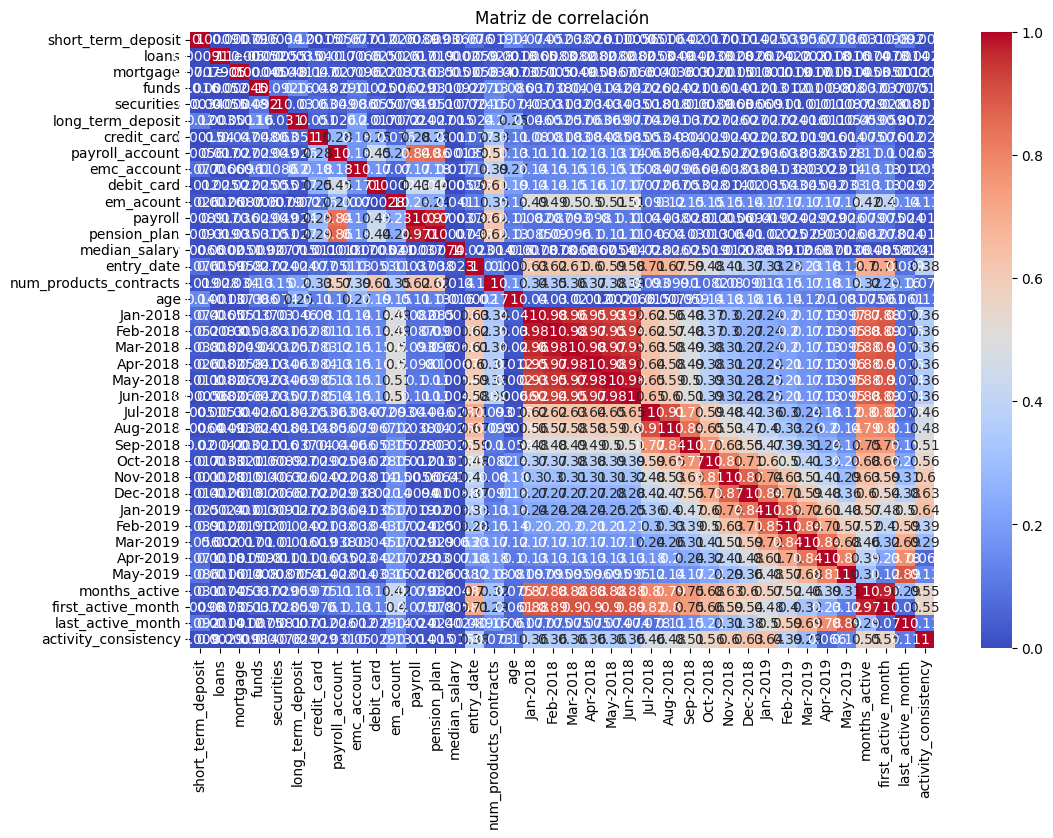

Columnas que no pasan al siguiente análisis debido a alta correlación: ['pension_plan', 'Feb-2018', 'Mar-2018', 'Apr-2018', 'May-2018', 'Jun-2018', 'Aug-2018', 'first_active_month']


In [30]:


# 1. Cargar el dataset
X_full = df_iterac_2.copy()

y = X_full['compra']  # Variable objetivo
X_full.drop(['compra'], axis=1, inplace=True)

# 4. Dividir los datos en entrenamiento (60%), validación (20%) y test (20%)
# El 60% de los datos originales se asigna al conjunto de entrenamiento (X_train_full y y_train).
# El 40% restante se divide en dos partes iguales: el 20% para el conjunto de validación (X_valid_full y y_valid) 
# y el 20% para el conjunto de prueba (X_test_full y y_test).
X_train_full, X_temp, y_train, y_temp = train_test_split(X_full, y, train_size=0.6, test_size=0.4, random_state=11, stratify=y)
X_valid_full, X_test_full, y_valid, y_test = train_test_split(X_temp, y_temp, train_size=0.5, test_size=0.5, random_state=11, stratify=y_temp)

# 5. Seleccionar columnas categóricas y numéricas
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype == "category"]
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]
my_cols = categorical_cols + numerical_cols 
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()
    
#---------------------------------------------------------

# 1. Calcular la matriz de correlación para las columnas numéricas
correlation_matrix = X_train[numerical_cols].corr().abs()

# 2. Visualizar la matriz de correlación como un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Matriz de correlación")
plt.show()

# 3. Identificar columnas con correlación mayor a 0.90
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Encuentra las columnas que tienen correlación > 0.90
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]

# 4. Eliminar columnas con alta correlación en el conjunto de entrenamiento
X_train = X_train.drop(columns=to_drop)
X_valid = X_valid.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

# Mostrar columnas eliminadas
print("Columnas que no pasan al siguiente análisis debido a alta correlación:", to_drop)

#---------------------------------------------------------



#### Definición del preprocesamiento, definición de los modelos, entrenamiento y evaluación de cada uno de los modelos seleccionados.

In [31]:
# 6. Preprocesamiento de los datos
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ]
)

# 7. Definir modelos a evaluar
models = {
    'RandomForest': RandomForestClassifier(random_state=11, n_jobs=-1),
    "LogisticRegression": LogisticRegression(random_state=11, n_jobs=-1),
    "XGBClassifier": XGBClassifier(random_state=11, n_jobs=-1),
      # "KNN": KNeighborsClassifier( n_jobs=-1),
    # "SVM": SVC( random_state=11),
}

# Diccionario para almacenar las importancias de características por modelo
feature_importances = {}

# 8. Entrenar y evaluar cada modelo
tabla_metricas = pd.DataFrame(columns=['Modelo', "accuracy", "roc_auc", "f1_score", "precision", "recall"])

for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Entrenar el modelo
    clf.fit(X_train, y_train)
    
    # Predicciones
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]
    
    # Calcular métricas
    accuracy = accuracy_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_pred_proba)
    f1 = f1_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    
    # Añadir las métricas a la tabla
    new_row = pd.DataFrame({'Modelo': [name], 'accuracy': [accuracy], 
                            'roc_auc': [roc_auc], 'f1_score': [f1], 
                            'precision': [precision], 'recall': [recall]})
    tabla_metricas = pd.concat([tabla_metricas, new_row], ignore_index=True)
    
    # Extraer e integrar las importancias de las características según el modelo
    if hasattr(model, 'feature_importances_'):  # Para RandomForest y XGBClassifier
        # Obtener las importancias de características del modelo
        importances = model.feature_importances_
        feature_names = clf.named_steps['preprocessor'].transformers_[0][1]['onehot'].get_feature_names_out(categorical_cols)
        feature_importances[name] = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    
    elif hasattr(model, 'coef_'):  # Para LogisticRegression
        # Obtener los coeficientes del modelo
        coefficients = model.coef_[0]
        feature_names = clf.named_steps['preprocessor'].transformers_[0][1]['onehot'].get_feature_names_out(categorical_cols)
        feature_importances[name] = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})

# 11. Mostrar las métricas
print("Tabla de métricas:")
print(tabla_metricas)

# 12. Mostrar las importancias de las características por cada modelo
for model_name, importance_df in feature_importances.items():
    print(f"Importancias de características para {model_name}:")
    print(importance_df.sort_values(by='Importance', ascending=False))

Tabla de métricas:
               Modelo  accuracy  roc_auc  f1_score  precision  recall
0        RandomForest     0.764    0.750     0.852      0.784   0.932
1  LogisticRegression     0.734    0.714     0.838      0.751   0.949
2       XGBClassifier     0.767    0.757     0.855      0.781   0.943
Importancias de características para RandomForest:
                           Feature  Importance
52              region_code_Madrid       0.194
5   categoria_antiguedad_0-3 meses       0.091
21             entry_channel_Otros       0.052
3        segment_02 - PARTICULARES       0.047
16               entry_channel_KHE       0.046
..                             ...         ...
66               region_code_Soria       0.001
68              region_code_Teruel       0.001
34               region_code_Ceuta       0.001
53             region_code_Melilla       0.001
41          region_code_Extranjero       0.001

[76 rows x 2 columns]
Importancias de características para LogisticRegression:
      

#### Comparación de modelos

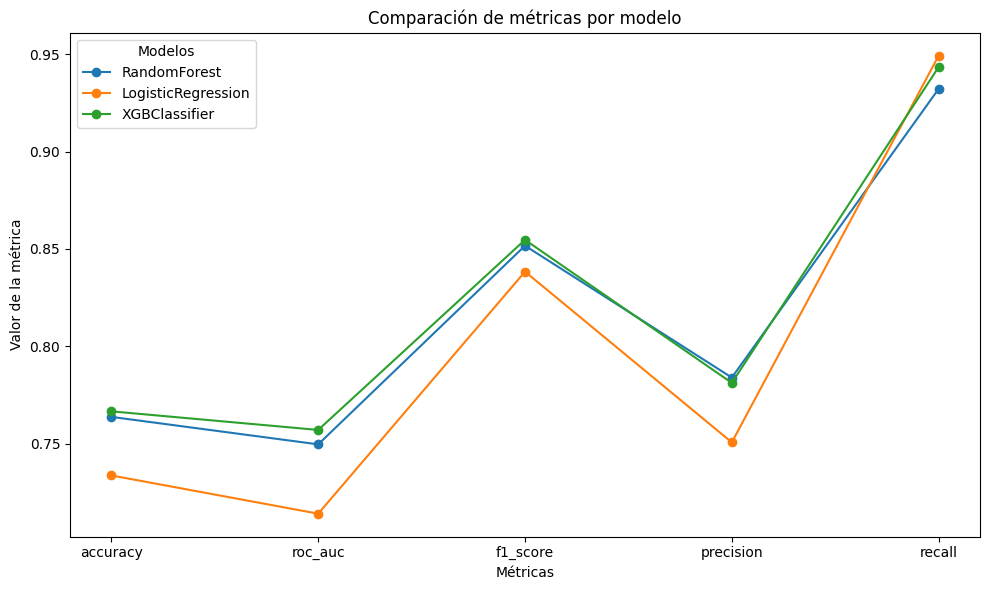

In [32]:
# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Definir las métricas que se usarán como etiquetas en el eje X
metricas = ['accuracy', 'roc_auc', 'f1_score', 'precision', 'recall']

# Graficar una línea por cada modelo
for modelo in tabla_metricas['Modelo']:
    plt.plot(metricas, tabla_metricas[tabla_metricas['Modelo'] == modelo].iloc[0, 1:], marker='o', label=modelo)

# Añadir etiquetas y título
plt.xlabel('Métricas')
plt.ylabel('Valor de la métrica')
plt.title('Comparación de métricas por modelo')
plt.legend(title='Modelos')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### 3. Iteracion 3.

In [34]:
df_iterac_3 = df_iterac_2.copy()
df_iterac_3

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll_account,emc_account,debit_card,em_acount,payroll,pension_plan,gender,median_salary,entry_date,active_customer,segment,categoria_antiguedad,num_products_contracts,age,compra,Jan-2018,Feb-2018,Mar-2018,Apr-2018,May-2018,Jun-2018,Jul-2018,Aug-2018,Sep-2018,Oct-2018,Nov-2018,Dec-2018,Jan-2019,Feb-2019,Mar-2019,Apr-2019,May-2019,months_active,first_active_month,last_active_month,activity_consistency,entry_channel,region_code
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,0.000,0.000,H,"117,380.925",736903,0,02 - PARTICULARES,0-3 meses,0,59,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2,736903,736934,2.000,KAT,Madrid
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,H,"132,384.450",737017,0,02 - PARTICULARES,6-9 meses,0,62,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,7,737026,737207,1.167,KAT,Madrid
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833,0.000,0.000,V,"153,902.880",737051,1,01 - TOP,3-6 meses,1,70,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6,737056,737207,1.200,KAT,Barcelona
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.889,0.000,0.000,H,"132,384.450",736967,1,02 - PARTICULARES,6-9 meses,2,58,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,9,736965,737207,1.125,KHN,Madrid
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.294,1.000,0.000,0.000,H,"102,405.750",736588,1,02 - PARTICULARES,1-2 años,3,54,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,17,736722,737207,1.062,KAT,Madrid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,V,"114,633.765",737210,0,03 - UNIVERSITARIO,0-3 meses,0,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,737207,737207,1.000,Otros,Ciudad Real
1553686,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,H,"85,787.220",737210,0,03 - UNIVERSITARIO,0-3 meses,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,737207,737207,1.000,Otros,Sevilla
1553687,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,V,"143,419.770",737210,0,03 - UNIVERSITARIO,0-3 meses,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,737207,737207,1.000,Otros,Madrid


In [35]:
# 2. Aplicar pd.get_dummies() a las columnas categóricas
df_encoded = pd.get_dummies(df_iterac_3, columns=categorical_cols, dtype= int)  # drop_first=True para evitar multicolinealidad

df_encoded

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll_account,emc_account,debit_card,em_acount,payroll,pension_plan,median_salary,entry_date,active_customer,num_products_contracts,age,compra,Jan-2018,Feb-2018,Mar-2018,Apr-2018,May-2018,Jun-2018,Jul-2018,Aug-2018,Sep-2018,Oct-2018,Nov-2018,Dec-2018,Jan-2019,Feb-2019,Mar-2019,Apr-2019,May-2019,months_active,first_active_month,last_active_month,activity_consistency,gender_H,gender_V,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,categoria_antiguedad_0-3 meses,categoria_antiguedad_3-6 meses,categoria_antiguedad_6-9 meses,categoria_antiguedad_9-12 meses,categoria_antiguedad_1-2 años,...,region_code_Asturias,region_code_Badajoz,"region_code_Baleares, Islas",region_code_Barcelona,region_code_Bizkaia,region_code_Burgos,region_code_Cantabria,region_code_Castellón,region_code_Ceuta,region_code_Ciudad Real,"region_code_Coruña, A",region_code_Cuenca,region_code_Cáceres,region_code_Cádiz,region_code_Córdoba,region_code_Extranjero,region_code_Gipuzkoa,region_code_Girona,region_code_Granada,region_code_Guadalajara,region_code_Huelva,region_code_Huesca,region_code_Jaén,region_code_León,region_code_Lleida,region_code_Lugo,region_code_Madrid,region_code_Melilla,region_code_Murcia,region_code_Málaga,region_code_Navarra,region_code_Ourense,region_code_Palencia,"region_code_Palmas, Las",region_code_Pontevedra,"region_code_Rioja, La",region_code_Salamanca,region_code_Santa Cruz de Tenerife,region_code_Segovia,region_code_Sevilla,region_code_Soria,region_code_Tarragona,region_code_Teruel,region_code_Toledo,region_code_Valencia,region_code_Valladolid,region_code_Zamora,region_code_Zaragoza,region_code_Álava,region_code_Ávila
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,0.000,0.000,"117,380.925",736903,0,0,59,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2,736903,736934,2.000,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,"132,384.450",737017,0,0,62,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,7,737026,737207,1.167,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833,0.000,0.000,"153,902.880",737051,1,1,70,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6,737056,737207,1.200,0,1,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.889,0.000,0.000,"132,384.450",736967,1,2,58,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,9,736965,737207,1.125,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.294,1.000,0.000,0.000,"102,405.750",736588,1,3,54,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,17,736722,737207,1.062,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,"114,633.765",737210,0,0,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,737207,737207,1.000,0,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [51]:
from autofeat import AutoFeatRegressor

# Por ejemplo, supongamos que 'age' es la columna objetivo (target)
X = df_encoded.drop(columns='compra')  # Variables independientes (features)
y = df_encoded['compra']               # Variable objetivo (target)


# Dividimos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# 1. Crear el modelo de AutoFeat
# auto_feat_regressor es adecuado si el problema es de regresión (puedes usar AutoFeatClassifier para clasificación)
afreg = AutoFeatRegressor(verbose=1, feateng_steps=1.5)  # Puedes ajustar feateng_steps para más/menos características

# 2. Ajustar el modelo para generar nuevas características
X_train_transformed = afreg.fit_transform(X_train, y_train)

# 3. Transformar los datos de prueba usando las nuevas características
X_test_transformed = afreg.transform(X_test)


# Revisar las nuevas características creadas
print("Número de características originales:", X_train.shape[1])
print("Número de nuevas características creadas:", X_train_transformed.shape[1])
print("Nuevas características generadas:\n", X_train_transformed.head())

2024-09-11 13:54:51,235 INFO: [AutoFeat] The 1.5 step feature engineering process could generate up to 805 features.
2024-09-11 13:54:51,235 INFO: [AutoFeat] With 365098 data points this new feature matrix would use about 1.18 gb of space.
2024-09-11 13:54:51,399 INFO: [feateng] Step 1: transformation of original features


2024-09-11 13:54:53,300 INFO: [feateng] Generated 83 transformed features from 115 original features - done.


2024-09-11 13:54:53,549 INFO: [feateng] Generated altogether 101 new features in 1.5 steps
2024-09-11 13:54:53,549 INFO: [feateng] Removing correlated features, as well as additions at the highest level
2024-09-11 13:54:53,833 INFO: [feateng] Generated a total of 18 additional features


[featsel] Scaling data...

2024-09-11 13:54:54,153 INFO: [featsel] Feature selection run 1/5


done.


2024-09-11 13:55:22,803 INFO: [featsel] Feature selection run 2/5
2024-09-11 13:55:48,533 INFO: [featsel] Feature selection run 3/5
2024-09-11 13:56:08,340 INFO: [featsel] Feature selection run 4/5
2024-09-11 13:56:40,165 INFO: [featsel] Feature selection run 5/5
2024-09-11 13:57:04,024 INFO: [featsel] 65 features after 5 feature selection runs
2024-09-11 13:57:12,291 INFO: [featsel] 56 features after correlation filtering
2024-09-11 13:57:17,804 INFO: [featsel] 50 features after noise filtering
2024-09-11 13:57:17,810 INFO: [AutoFeat] Computing 5 new features.


2024-09-11 13:57:18,184 INFO: [AutoFeat]     5/    5 new features ...done.


2024-09-11 13:57:18,285 INFO: [AutoFeat] Final dataframe with 120 feature columns (5 new).
2024-09-11 13:57:18,285 INFO: [AutoFeat] Training final regression model.
2024-09-11 13:57:20,015 INFO: [AutoFeat] Trained model: largest coefficients:
2024-09-11 13:57:20,016 INFO: -0.3659586030435975
2024-09-11 13:57:20,016 INFO: 0.518565 * em_acount
2024-09-11 13:57:20,017 INFO: -0.420612 * 1/age
2024-09-11 13:57:20,018 INFO: 0.419524 * payroll_account
2024-09-11 13:57:20,019 INFO: 0.347007 * num_products_contracts
2024-09-11 13:57:20,020 INFO: 0.290686 * mortgage
2024-09-11 13:57:20,021 INFO: 0.236500 * 1/months_active
2024-09-11 13:57:20,022 INFO: -0.234404 * debit_card
2024-09-11 13:57:20,025 INFO: -0.158386 * securities
2024-09-11 13:57:20,026 INFO: 0.142113 * loans
2024-09-11 13:57:20,027 INFO: -0.133058 * funds
2024-09-11 13:57:20,031 INFO: 0.120674 * May-2019
2024-09-11 13:57:20,034 INFO: 0.120296 * Apr-2019
2024-09-11 13:57:20,035 INFO: 0.101345 * categoria_antiguedad_3-6 meses
2024-09

Número de características originales: 115
Número de nuevas características creadas: 120
Nuevas características generadas:
    short_term_deposit  loans  mortgage  funds  securities  long_term_deposit  \
0               0.000  0.000     0.000  0.000       0.000              0.000   
1               0.000  0.000     0.000  0.000       0.000              0.000   
2               0.000  0.000     0.000  0.000       0.000              0.000   
3               0.000  0.000     0.000  0.000       0.000              0.000   
4               0.000  0.000     0.000  0.000       0.000              0.000   

   credit_card  payroll_account  emc_account  debit_card  em_acount  payroll  \
0        0.000            0.000        0.000       0.000      1.000    0.000   
1        0.000            0.000        0.000       0.000      1.000    0.000   
2        0.000            0.000        0.000       0.000      1.000    0.000   
3        0.000            0.000        0.000       0.000      1.000    0.000


Descripción de las nuevas características:

	1.	1/age:
	•	Significado: Esta característica representa el inverso de la columna age (edad). Es una transformación común cuando se desea resaltar la influencia de valores pequeños, porque el inverso de un número grande es pequeño, y viceversa.
	•	Fórmula:  \text{Inverso de la edad} = \frac{1}{\text{age}} 
	•	Propósito: Destacar la influencia de los valores pequeños de edad o eliminar el efecto de números grandes.
	2.	1/months_active:
	•	Significado: Similar a 1/age, representa el inverso del número de meses que el cliente ha estado activo.
	•	Fórmula:  \text{Inverso de meses activos} = \frac{1}{\text{months\_active}} 
	•	Propósito: Para transformar una variable que cuenta tiempo en algo que capture la importancia de clientes que han estado menos tiempo activos (número pequeño de meses activos tiene un valor mayor aquí).
	3.	log(median_salary):
	•	Significado: Esta característica es el logaritmo natural del salario medio (median_salary).
	•	Fórmula:  \text{Log de salario medio} = \log(\text{median\_salary}) 
	•	Propósito: Aplicar el logaritmo a una variable como el salario puede suavizar la escala, ayudando a reducir el impacto de valores extremadamente grandes.
	4.	num_products_contracts**3:
	•	Significado: Esta característica es el cubo del número de productos contratados (num_products_contracts).
	•	Fórmula:  \text{Número de productos contratados al cubo} = (\text{num\_products\_contracts})^3 
	•	Propósito: Potenciar la importancia de la variable de productos contratados, al aplicar una potencia cúbica se magnifica la diferencia entre valores.
	5.	exp(num_products_contracts):
	•	Significado: Esta característica es la exponencial de num_products_contracts.
	•	Fórmula:  \text{Exponencial del número de productos} = e^{\text{num\_products\_contracts}} 
	•	Propósito: Este tipo de transformación es útil para hacer que pequeñas diferencias en la variable se amplifiquen de manera exponencial.

In [52]:
# Crear un DataFrame de ejemplo (suponiendo que ya tienes un DataFrame llamado df)
# Aquí replicaremos las nuevas características en tu DataFrame original

# 1. Inverso de la edad (1/age)
df_iterac_3['1/age'] = 1 / df_iterac_3['age'].replace(0, np.nan)  # Evita la división por 0 reemplazando 0 por NaN

# 2. Inverso de meses activos (1/months_active)
df_iterac_3['1/months_active'] = 1 / df_iterac_3['months_active'].replace(0, np.nan)

# 3. Logaritmo del salario medio (log(median_salary))
df_iterac_3['log(median_salary)'] = np.log(df_iterac_3['median_salary'].replace(0, np.nan))  # Evita log(0)

# 4. Cubo del número de productos contratados (num_products_contracts**3)
df_iterac_3['num_products_contracts**3'] = df_iterac_3['num_products_contracts'] ** 3

# 5. Exponencial del número de productos contratados (exp(num_products_contracts))
df_iterac_3['exp(num_products_contracts)'] = np.exp(df_iterac_3['num_products_contracts'])

df_iterac_3

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll_account,emc_account,debit_card,em_acount,payroll,pension_plan,gender,median_salary,entry_date,active_customer,segment,categoria_antiguedad,num_products_contracts,age,compra,Jan-2018,Feb-2018,Mar-2018,Apr-2018,May-2018,Jun-2018,Jul-2018,Aug-2018,Sep-2018,Oct-2018,Nov-2018,Dec-2018,Jan-2019,Feb-2019,Mar-2019,Apr-2019,May-2019,months_active,first_active_month,last_active_month,activity_consistency,entry_channel,region_code,1/age,1/months_active,log(median_salary),num_products_contracts**3,exp(num_products_contracts)
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,0.000,0.000,H,"117,380.925",736903,0,02 - PARTICULARES,0-3 meses,0,59,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2,736903,736934,2.000,KAT,Madrid,0.017,0.500,11.673,0,1.000
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,H,"132,384.450",737017,0,02 - PARTICULARES,6-9 meses,0,62,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,7,737026,737207,1.167,KAT,Madrid,0.016,0.143,11.793,0,1.000
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833,0.000,0.000,V,"153,902.880",737051,1,01 - TOP,3-6 meses,1,70,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6,737056,737207,1.200,KAT,Barcelona,0.014,0.167,11.944,1,2.718
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.889,0.000,0.000,H,"132,384.450",736967,1,02 - PARTICULARES,6-9 meses,2,58,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,9,736965,737207,1.125,KHN,Madrid,0.017,0.111,11.793,8,7.389
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.294,1.000,0.000,0.000,H,"102,405.750",736588,1,02 - PARTICULARES,1-2 años,3,54,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,17,736722,737207,1.062,KAT,Madrid,0.019,0.059,11.537,27,20.086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,V,"114,633.765",737210,0,03 - UNIVERSITARIO,0-3 meses,0,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,737207,737207,1.000,Otros,Ciudad Real,0.019,1.000,11.649,0,1.000
1553686,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,H,"85,787.220",737210,0,03 - UNIVERSITARIO,0-3 meses,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,737207,737207,1.000,Otros,Sevilla,0.033,1.000,11.360,0,1.000
1553687,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,V,"143,419.770",737210,0,03 - UNIVERSITARIO,0-3 meses,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,737207,737207,1.000,Otros,Madrid,0.048,1.000,11.874,0,1.000


In [59]:
# Crear algunas interacciones
df_iterac_3['age_salary_interaction'] = df_iterac_3['age'] * df_iterac_3['median_salary']
df_iterac_3['products_per_month_active'] = df_iterac_3['num_products_contracts'] / df_iterac_3['months_active'].replace(0, np.nan)
# Crear el salario medio por región
df_iterac_3['avg_salary_by_region'] = df_iterac_3.groupby('region_code')['median_salary'].transform('mean')

# Número de productos promedio por segmento
df_iterac_3['avg_products_by_segment'] = df_iterac_3.groupby('segment')['num_products_contracts'].transform('mean')



# Crear bins para la edad
df_iterac_3['age_bins'] = pd.cut(df_iterac_3['age'], bins=[18, 30, 45, 60, 75, 90], labels=['Joven', 'Adulto Joven', 'Adulto', 'Mayor', 'Senior'])


# Detectar y reemplazar outliers en salario
q1 = df_iterac_3['median_salary'].quantile(0.25)
q3 = df_iterac_3['median_salary'].quantile(0.75)
iqr = q3 - q1  # Rango intercuartílico
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Reemplazar los outliers con NaN o con un valor determinado
df_iterac_3['median_salary'] = np.where((df_iterac_3['median_salary'] < lower_bound) | (df_iterac_3['median_salary'] > upper_bound), np.nan, df_iterac_3['median_salary'])
df_iterac_3['median_salary'] = df_iterac_3['median_salary'].fillna(df_iterac_3['median_salary'].mean())  # Imputar con la media

In [60]:
df_iterac_3

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll_account,emc_account,debit_card,em_acount,payroll,pension_plan,gender,median_salary,entry_date,active_customer,segment,categoria_antiguedad,num_products_contracts,age,compra,Jan-2018,Feb-2018,Mar-2018,Apr-2018,May-2018,Jun-2018,Jul-2018,Aug-2018,Sep-2018,Oct-2018,Nov-2018,Dec-2018,Jan-2019,Feb-2019,Mar-2019,Apr-2019,May-2019,months_active,first_active_month,last_active_month,activity_consistency,entry_channel,region_code,1/age,1/months_active,log(median_salary),num_products_contracts**3,exp(num_products_contracts),age_salary_interaction,products_per_month_active,avg_salary_by_region,avg_products_by_segment,months_since_first_active,age_bins
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,0.000,0.000,H,"117,380.925",736903,0,02 - PARTICULARES,0-3 meses,0,59,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2,736903,736934,2.000,KAT,Madrid,0.017,0.500,11.673,0,1.000,"6,925,474.575",0.000,"155,598.271",1.139,1.033,Adulto
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,H,"132,384.450",737017,0,02 - PARTICULARES,6-9 meses,0,62,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,7,737026,737207,1.167,KAT,Madrid,0.016,0.143,11.793,0,1.000,"8,207,835.900",0.000,"155,598.271",1.139,6.033,Mayor
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833,0.000,0.000,V,"153,902.880",737051,1,01 - TOP,3-6 meses,1,70,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6,737056,737207,1.200,KAT,Barcelona,0.014,0.167,11.944,1,2.718,"10,773,201.600",0.167,"148,876.882",1.995,5.033,Mayor
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.889,0.000,0.000,H,"132,384.450",736967,1,02 - PARTICULARES,6-9 meses,2,58,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,9,736965,737207,1.125,KHN,Madrid,0.017,0.111,11.793,8,7.389,"7,678,298.100",0.222,"155,598.271",1.139,8.067,Adulto
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.294,1.000,0.000,0.000,H,"102,405.750",736588,1,02 - PARTICULARES,1-2 años,3,54,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,17,736722,737207,1.062,KAT,Madrid,0.019,0.059,11.537,27,20.086,"5,529,910.500",0.176,"155,598.271",1.139,16.167,Adulto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,V,"114,633.765",737210,0,03 - UNIVERSITARIO,0-3 meses,0,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,737207,737207,1.000,Otros,Ciudad Real,0.019,1.000,11.649,0,1.000,"5,960,955.780",0.000,"66,594.364",0.846,0.000,Adulto
1553686,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,H,"85,787.220",737210,0,03 - UNIVERSITARIO,0-3 meses,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,737207,737207,1.000,Otros,Sevilla,0.033,1.000,11.360,0,1.000,"2,573,616.600",0.000,"109,409.162",0.846,0.000,Joven
1553687,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,V,"143,419.770",737210,0,03 - UNIVERSITARIO,0-3 meses,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,737207,737207,1.000,Otros,Madrid,0.048,1.000,11.874,0,1.000,"3,011,815.170",0.000,"155,598.271",0.846,0.000,Joven


#### División de los conjuntos, selección de columnas numericas y categóricas y analisis de correlación de las numéricas.

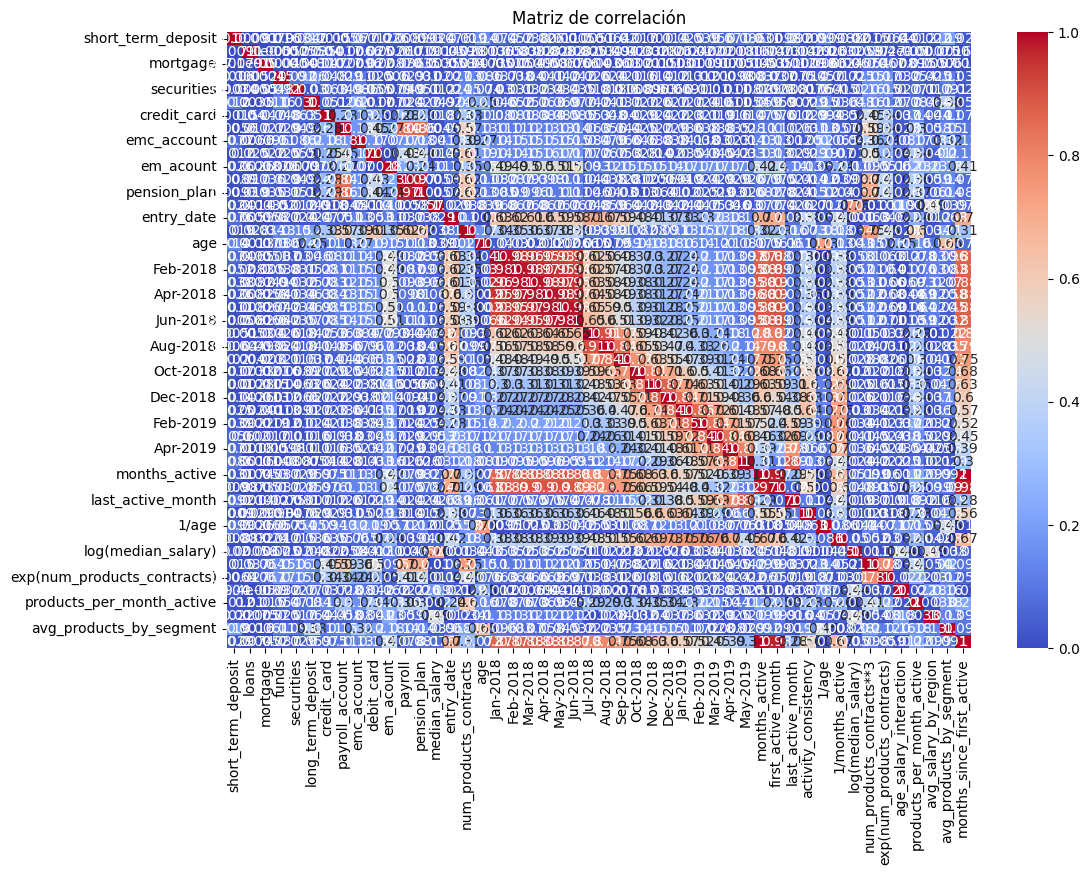

Columnas que no pasan al siguiente análisis debido a alta correlación: ['pension_plan', 'Feb-2018', 'Mar-2018', 'Apr-2018', 'May-2018', 'Jun-2018', 'Aug-2018', 'first_active_month', 'months_since_first_active']


In [61]:


# 1. Cargar el dataset
X_full = df_iterac_3.copy()

y = X_full['compra']  # Variable objetivo
X_full.drop(['compra'], axis=1, inplace=True)

# 4. Dividir los datos en entrenamiento (60%), validación (20%) y test (20%)
# El 60% de los datos originales se asigna al conjunto de entrenamiento (X_train_full y y_train).
# El 40% restante se divide en dos partes iguales: el 20% para el conjunto de validación (X_valid_full y y_valid) 
# y el 20% para el conjunto de prueba (X_test_full y y_test).
X_train_full, X_temp, y_train, y_temp = train_test_split(X_full, y, train_size=0.6, test_size=0.4, random_state=11, stratify=y)
X_valid_full, X_test_full, y_valid, y_test = train_test_split(X_temp, y_temp, train_size=0.5, test_size=0.5, random_state=11, stratify=y_temp)

# 5. Seleccionar columnas categóricas y numéricas
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype == "category"]
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]
my_cols = categorical_cols + numerical_cols 
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()
    
#---------------------------------------------------------

# 1. Calcular la matriz de correlación para las columnas numéricas
correlation_matrix = X_train[numerical_cols].corr().abs()

# 2. Visualizar la matriz de correlación como un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Matriz de correlación")
plt.show()

# 3. Identificar columnas con correlación mayor a 0.90
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Encuentra las columnas que tienen correlación > 0.90
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]

# 4. Eliminar columnas con alta correlación en el conjunto de entrenamiento
X_train = X_train.drop(columns=to_drop)
X_valid = X_valid.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

# Mostrar columnas eliminadas
print("Columnas que no pasan al siguiente análisis debido a alta correlación:", to_drop)

#---------------------------------------------------------



#### Definición del preprocesamiento, definición de los modelos, entrenamiento y evaluación de cada uno de los modelos seleccionados.

In [62]:
# 6. Preprocesamiento de los datos
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('onehot', OneHotEncoder())
        ]), categorical_cols)
    ]
)

# 7. Definir modelos a evaluar
models = {
    'RandomForest': RandomForestClassifier(random_state=11, n_jobs=-1),
    "LogisticRegression": LogisticRegression(random_state=11, n_jobs=-1),
    "XGBClassifier": XGBClassifier(random_state=11, n_jobs=-1),
      # "KNN": KNeighborsClassifier( n_jobs=-1),
    # "SVM": SVC( random_state=11),
}

# Diccionario para almacenar las importancias de características por modelo
feature_importances = {}

# 8. Entrenar y evaluar cada modelo
tabla_metricas = pd.DataFrame(columns=['Modelo', "accuracy", "roc_auc", "f1_score", "precision", "recall"])

for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Entrenar el modelo
    clf.fit(X_train, y_train)
    
    # Predicciones
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]
    
    # Calcular métricas
    accuracy = accuracy_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_pred_proba)
    f1 = f1_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    
    # Añadir las métricas a la tabla
    new_row = pd.DataFrame({'Modelo': [name], 'accuracy': [accuracy], 
                            'roc_auc': [roc_auc], 'f1_score': [f1], 
                            'precision': [precision], 'recall': [recall]})
    tabla_metricas = pd.concat([tabla_metricas, new_row], ignore_index=True)
    
    # Extraer e integrar las importancias de las características según el modelo
    if hasattr(model, 'feature_importances_'):  # Para RandomForest y XGBClassifier
        # Obtener las importancias de características del modelo
        importances = model.feature_importances_
        feature_names = clf.named_steps['preprocessor'].transformers_[0][1]['onehot'].get_feature_names_out(categorical_cols)
        feature_importances[name] = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    
    elif hasattr(model, 'coef_'):  # Para LogisticRegression
        # Obtener los coeficientes del modelo
        coefficients = model.coef_[0]
        feature_names = clf.named_steps['preprocessor'].transformers_[0][1]['onehot'].get_feature_names_out(categorical_cols)
        feature_importances[name] = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})

# 11. Mostrar las métricas
print("Tabla de métricas:")
print(tabla_metricas)

# 12. Mostrar las importancias de las características por cada modelo
for model_name, importance_df in feature_importances.items():
    print(f"Importancias de características para {model_name}:")
    print(importance_df.sort_values(by='Importance', ascending=False))

Tabla de métricas:
               Modelo  accuracy  roc_auc  f1_score  precision  recall
0        RandomForest     0.766    0.747     0.851      0.792   0.920
1  LogisticRegression     0.741    0.721     0.843      0.754   0.956
2       XGBClassifier     0.773    0.763     0.858      0.790   0.938
Importancias de características para RandomForest:
                           Feature  Importance
52              region_code_Madrid       0.163
5   categoria_antiguedad_0-3 meses       0.073
21             entry_channel_Otros       0.041
81                    age_bins_nan       0.039
29           region_code_Barcelona       0.038
..                             ...         ...
34               region_code_Ceuta       0.001
66               region_code_Soria       0.001
53             region_code_Melilla       0.001
68              region_code_Teruel       0.001
41          region_code_Extranjero       0.001

[82 rows x 2 columns]
Importancias de características para LogisticRegression:
      

sacar feutre, despues hacer lo que tengo abajo, hiperparameyros y a correr